# Visualize PCA of weight, activity and Estimates MI from data

## Import lib

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader , TensorDataset
from torchvision.utils import save_image, make_grid
from torch.optim import Adam
import torch.nn.init as init

import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MultipleLocator
import matplotlib.cm as cm

import copy
import seaborn as sns

from scipy.stats import norm
from sklearn.neighbors import KernelDensity, LocalOutlierFactor
from sklearn.decomposition import PCA

import tqdm

import pickle

# MI estimators
from utils.estimators import *

## Load data

In [391]:
with open("data/weight_dynamic/HEBB-FULL_STATE-seed_0-rand-0.pkl", "rb") as f:
    loaded_buffer = pickle.load(f)
with open("data/weight_dynamic/ZERO-HEBB-FULL_STATE-seed_0-rand-0.pkl", "rb") as m:
    loaded_zero = pickle.load(m)
with open("data/weight_dynamic/ZERO_LONG-HEBB-FULL_STATE-seed_0-rand-0.pkl", "rb") as m:
    loaded_zero_long = pickle.load(m)

In [392]:
def reshape_to_single(val):
    '''
    Input dim : [timestep , np:[1,dim] ]
    Return dim : np: [timestep , dim]
    '''
    for i in range(len(val)):
        val[i] = val[i].reshape(-1)
    return np.array(val)

In [393]:
def select_activity_layer(activity,selected_layer):
    '''
    Input dim : [timestep][layer]
    Return dim : np: [timestep , dim]
    '''
    buff = []
    for t in range(len(activity)):
        layer = activity[t][selected_layer]
        buff.append(layer.reshape(-1) if isinstance(layer, np.ndarray) else layer.numpy().reshape(-1))
    return np.array(buff , dtype=object)

In [394]:
def select_weight_layer(weight,selected_layer):
    '''
    Input dim : [timestep][layer]
    Return dim : np: [timestep , dim]
    '''
    buff = []
    for t in range(len(weight)):
        _b = weight[t][selected_layer][0]
        buff.append(_b if isinstance(_b, np.ndarray) else _b.numpy())
    return np.array(buff , dtype=object)

Load Normal

In [395]:
normal = {}
load = loaded_buffer
activity    = load["brain"]["activity"]              # [timestep][layer_n][ 1 , hidden_dim]
weight      = load["brain"]["weight"]                # [timestep][layer_n][ 1 , 64 , 128]
normal["input"]       = reshape_to_single(load["data"]["state"])           # [timestep][1 , all_observation] ---reshape---> [timestep, all_obs]
normal["act_hid_1"]   = select_activity_layer(activity , 0)             # [timestep][layer_n][1 , hidden_dim] ---reshape---> [timestep, num_dim_of_selected_layer]
normal["act_hid_2"]   = select_activity_layer(activity , 1)
normal["weight_hid_1"] = select_weight_layer(weight,0)
normal["weight_hid_2"] = select_weight_layer(weight,1)
normal["weight_hid_3"] = select_weight_layer(weight,2)
normal["output"]      = reshape_to_single(load["data"]["action"])          # [timestep][1 , all_observation] ---reshape---> [timestep, all_obs]

Load Morph

In [396]:
zero = {}
load = loaded_zero
activity    = load["brain"]["activity"]              # [timestep][layer_n][ 1 , hidden_dim]
weight      = load["brain"]["weight"]                # [timestep][layer_n][ 1 , 64 , 128]
zero["input"]       = reshape_to_single(load["data"]["state"])           # [timestep][1 , all_observation] ---reshape---> [timestep, all_obs]
zero["act_hid_1"]   = select_activity_layer(activity , 0)             # [timestep][layer_n][1 , hidden_dim] ---reshape---> [timestep, num_dim_of_selected_layer]
zero["act_hid_2"]   = select_activity_layer(activity , 1)
zero["weight_hid_1"] = select_weight_layer(weight,0)
zero["weight_hid_2"] = select_weight_layer(weight,1)
zero["weight_hid_3"] = select_weight_layer(weight,2)
zero["output"]      = reshape_to_single(load["data"]["action"])          # [timestep][1 , all_observation] ---reshape---> [timestep, all_obs]
zero["torque"]      = reshape_to_single(load["data"]["torque"])
zero["reward"]      = reshape_to_single(load["data"]["reward"])

In [397]:
zero_long = {}
load = loaded_zero_long
activity    = load["brain"]["activity"]              # [timestep][layer_n][ 1 , hidden_dim]
weight      = load["brain"]["weight"]                # [timestep][layer_n][ 1 , 64 , 128]
zero_long["input"]       = reshape_to_single(load["data"]["state"])           # [timestep][1 , all_observation] ---reshape---> [timestep, all_obs]
zero_long["act_hid_1"]   = select_activity_layer(activity , 0)             # [timestep][layer_n][1 , hidden_dim] ---reshape---> [timestep, num_dim_of_selected_layer]
zero_long["act_hid_2"]   = select_activity_layer(activity , 1)
zero_long["weight_hid_1"] = select_weight_layer(weight,0)
zero_long["weight_hid_2"] = select_weight_layer(weight,1)
zero_long["weight_hid_3"] = select_weight_layer(weight,2)
zero_long["output"]      = reshape_to_single(load["data"]["action"])          # [timestep][1 , all_observation] ---reshape---> [timestep, all_obs]
zero_long["torque"]      = reshape_to_single(load["data"]["torque"])
zero_long["reward"]      = reshape_to_single(load["data"]["reward"])

## PCA of HIDDEN LAYER

In [ ]:
def PCA_plot3D_single(pca):
    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # Plot the transformed data
    ax.scatter(pca[:, 0], pca[:, 1], pca[:, 2], label='w_hid1_flat', c='r', marker='o' ,s=10)
    # Labels and title
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')
    ax.set_title('PCA')
    # Show legend
    ax.legend()
    # Show plot
    plt.show()

In [ ]:
def PCA_plot3D_three(pca1,pca2,pca3):
    # Create a figure with 3 subplots (1 row, 3 columns)
    fig = plt.figure(figsize=(15, 5))

    # First subplot (for w_hid1_flat)
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(pca1[:, 0], pca1[:, 1], pca1[:, 2], c='r', marker='o', s=10)
    ax1.set_xlabel('PCA Component 1')
    ax1.set_ylabel('PCA Component 2')
    ax1.set_zlabel('PCA Component 3')
    ax1.set_title('PCA data 1')

    # Second subplot (for w_hid2_flat)
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.scatter(pca2[:, 0], pca2[:, 1], pca2[:, 2], c='g', marker='o', s=10)
    ax2.set_xlabel('PCA Component 1')
    ax2.set_ylabel('PCA Component 2')
    ax2.set_zlabel('PCA Component 3')
    ax2.set_title('PCA data 2')

    # Third subplot (for w_hid3_flat)
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.scatter(pca3[:, 0], pca3[:, 1], pca3[:, 2], c='b', marker='o', s=10)
    ax3.set_xlabel('PCA Component 1')
    ax3.set_ylabel('PCA Component 2')
    ax3.set_zlabel('PCA Component 3')
    ax3.set_title('PCA data 3')

    # Show the plot
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

In [ ]:
def PCA_plot3D_3in1(pca1 , pca2 , pca3):
    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the transformed data
    ax.scatter(pca1[:, 0], pca1[:, 1], pca1[:, 2], label='pca1', c='r', marker='o' ,s=10)
    ax.scatter(pca2[:, 0], pca2[:, 1], pca2[:, 2], label='pca2', c='g', marker='o', s=10)
    ax.scatter(pca3[:, 0], pca3[:, 1], pca3[:, 2], label='w_hid3_flat', c='b', marker='o', s=10)

    # Labels and title
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')
    ax.set_title('PCA')
    # Show legend
    ax.legend()
    # Show plot
    plt.show()

In [ ]:
def PCA_plot3D_two(pca1,pca2):
    # Create a figure with 3 subplots (1 row, 3 columns)
    fig = plt.figure(figsize=(15, 5))

    # First subplot (for w_hid1_flat)
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(pca1[:, 0], pca1[:, 1], pca1[:, 2], c='r', marker='o', s=10)
    ax1.set_xlabel('PCA Component 1')
    ax1.set_ylabel('PCA Component 2')
    ax1.set_zlabel('PCA Component 3')
    ax1.set_title('PCA data 1')

    # Second subplot (for w_hid2_flat)
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(pca2[:, 0], pca2[:, 1], pca2[:, 2], c='g', marker='o', s=10)
    ax2.set_xlabel('PCA Component 1')
    ax2.set_ylabel('PCA Component 2')
    ax2.set_zlabel('PCA Component 3')
    ax2.set_title('PCA data 2')
    # Show the plot
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Zeroout weight


In [ ]:
def PCA_plot_single_component(pca_data):
    num_component = pca_data.shape[1]  # Number of PCA components (columns)
    fig = plt.figure(figsize=(8, 2 * num_component))
    
    for component_index in range(num_component):
        # First subplot (for each PCA dataset)
        ax = fig.add_subplot(num_component, 1, component_index + 1)
        
        # Plot the component (each principal component over time)
        ax.plot(pca_data[:, component_index], c='k', marker='o', markersize=1)
        
        # Labels and title
        ax.set_xlabel('Time Step', fontsize=8)
        ax.set_ylabel(f'PCA Component {component_index + 1}', fontsize=8)
        ax.set_title(f'PCA Component {component_index + 1}', fontsize=12)
    
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

In [442]:
def PCA_plot_compare_single_component(pca_data_list, focus=None, name:str=None):
    '''
    PCA components must have the same size
    Input : [[timestep , num_component], ... , [timestep , num_component]]
    focus: list with the range of indices to fill between (e.g., [200, 400])
    '''
    # Determine the number of components and datasets
    num_datasets = len(pca_data_list)  # Number of PCA datasets
    num_components = pca_data_list[0].shape[1]  # Number of PCA components (columns)
    
    # Create a figure with subplots for each component and dataset
    fig, axes = plt.subplots(num_components, num_datasets, figsize=(6 * num_datasets, 2 * num_components))
    
    for component_index in range(num_components):
        for dataset_index in range(num_datasets):
            ax = axes[component_index, dataset_index]
            pca_data = pca_data_list[dataset_index]
            
            # Plot the component (each principal component over time)
            ax.plot(pca_data[:, component_index], c='k', marker='o', markersize=0.5)
            
            # If 'focus' range is given, fill the region between the range
            if focus is not None:
                y_min = np.min(pca_data[:, component_index])
                y_max = np.max(pca_data[:, component_index])
                
                # Fill the area between the min and max y-values in the focus range
                ax.fill_between(range(focus[0], focus[1]), y_min, y_max, color='yellow', alpha=0.3)

            # Labels and title
            if component_index == num_components - 1:  # Only label x-axis for the last row
                ax.set_xlabel('Time Step', fontsize=8)
            if dataset_index == 0:  # Only label y-axis for the first column
                ax.set_ylabel(f'PCA Component {component_index + 1}', fontsize=8)
            
            # Optional title for each component
            # if dataset_index == 0:
            #     ax.set_title(f'PCA Component {component_index + 1}', fontsize=12)
    if name is not None:
        plt.savefig(f'{name}.png') 
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

Zero thing

In [ ]:
pca = PCA(n_components=5)
zero_hidden_weight = {}
zero_hidden_weight["layer1"] = zero["weight_hid_1"].reshape(zero["weight_hid_1"].shape[0] , -1)
zero_hidden_weight["layer2"] = zero["weight_hid_2"].reshape(zero["weight_hid_2"].shape[0] , -1)
zero_hidden_weight["layer3"] = zero["weight_hid_3"].reshape(zero["weight_hid_3"].shape[0] , -1)

zero_hidden_weight["PCA_layer1"] = pca.fit_transform(zero_hidden_weight["layer1"])
zero_hidden_weight["PCA_layer2"] = pca.fit_transform(zero_hidden_weight["layer2"])
zero_hidden_weight["PCA_layer3"] = pca.fit_transform(zero_hidden_weight["layer3"])

plot_list = [zero_hidden_weight["PCA_layer1"][0:600 , :] , zero_hidden_weight["PCA_layer2"][0:600 , :] ,zero_hidden_weight["PCA_layer3"][0:600 , :]]
PCA_plot_compare_single_component(plot_list , focus=[300,400])

Zero but Long

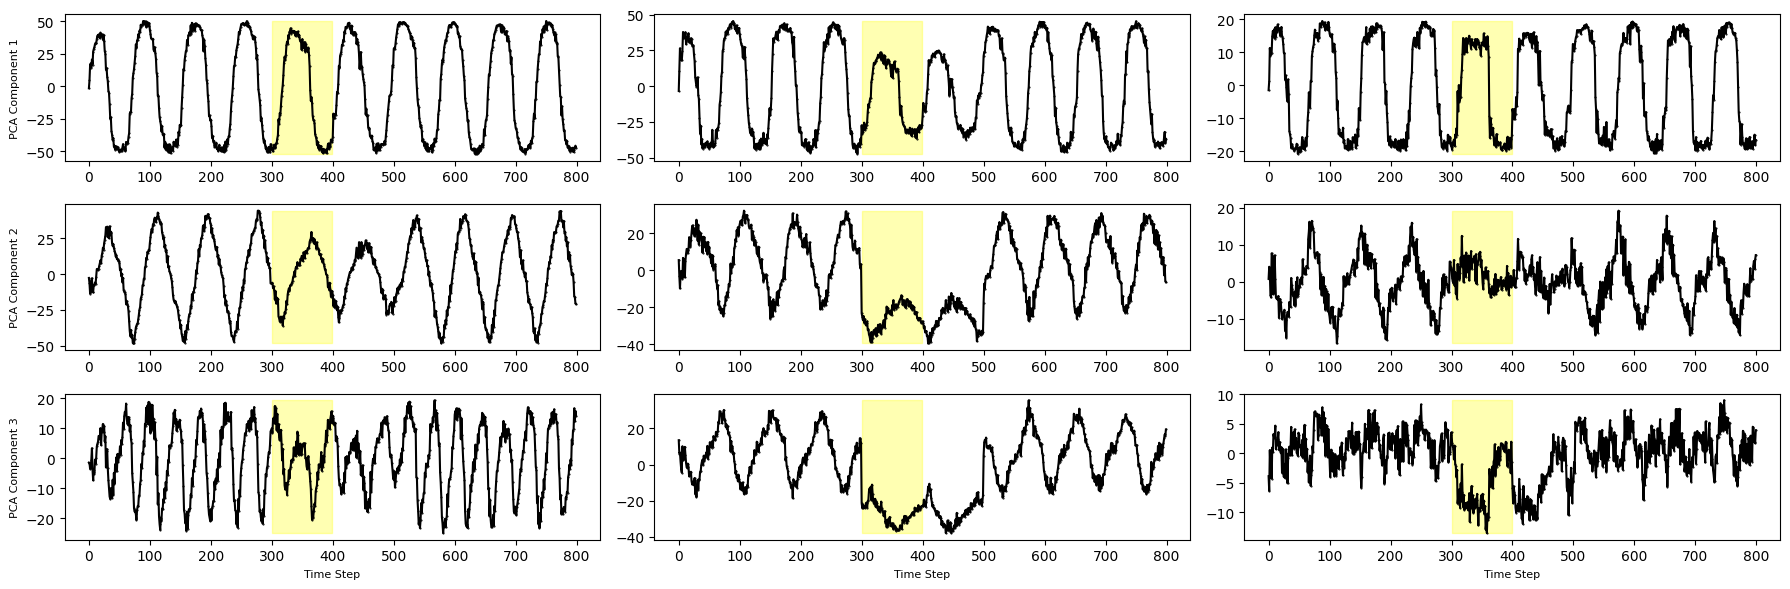

In [430]:
pca = PCA(n_components=3)
zero_long_hidden_weight = {}
zero_long_hidden_weight["layer1"] = zero_long["weight_hid_1"].reshape(zero_long["weight_hid_1"].shape[0] , -1)
zero_long_hidden_weight["layer2"] = zero_long["weight_hid_2"].reshape(zero_long["weight_hid_2"].shape[0] , -1)
zero_long_hidden_weight["layer3"] = zero_long["weight_hid_3"].reshape(zero_long["weight_hid_3"].shape[0] , -1)

zero_long_hidden_weight["PCA_layer1"] = pca.fit_transform(zero_long_hidden_weight["layer1"])
zero_long_hidden_weight["PCA_layer2"] = pca.fit_transform(zero_long_hidden_weight["layer2"])
zero_long_hidden_weight["PCA_layer3"] = pca.fit_transform(zero_long_hidden_weight["layer3"])

plot_list = [zero_long_hidden_weight["PCA_layer1"][0:800 , :] , zero_long_hidden_weight["PCA_layer2"][0:800 , :] ,zero_long_hidden_weight["PCA_layer3"][0:800 , :]]
PCA_plot_compare_single_component(plot_list , focus=[300,400])

Normal thing

In [387]:
normal_hidden_weight = {}
normal_hidden_weight["layer1"] = normal["weight_hid_1"].reshape(normal["weight_hid_1"].shape[0] , -1)
normal_hidden_weight["layer2"] = normal["weight_hid_2"].reshape(normal["weight_hid_2"].shape[0] , -1)
normal_hidden_weight["layer3"] = normal["weight_hid_3"].reshape(normal["weight_hid_3"].shape[0] , -1)

normal_hidden_weight["PCA_layer1"] = pca.fit_transform(normal_hidden_weight["layer1"])
normal_hidden_weight["PCA_layer2"] = pca.fit_transform(normal_hidden_weight["layer2"])
normal_hidden_weight["PCA_layer3"] = pca.fit_transform(normal_hidden_weight["layer3"])

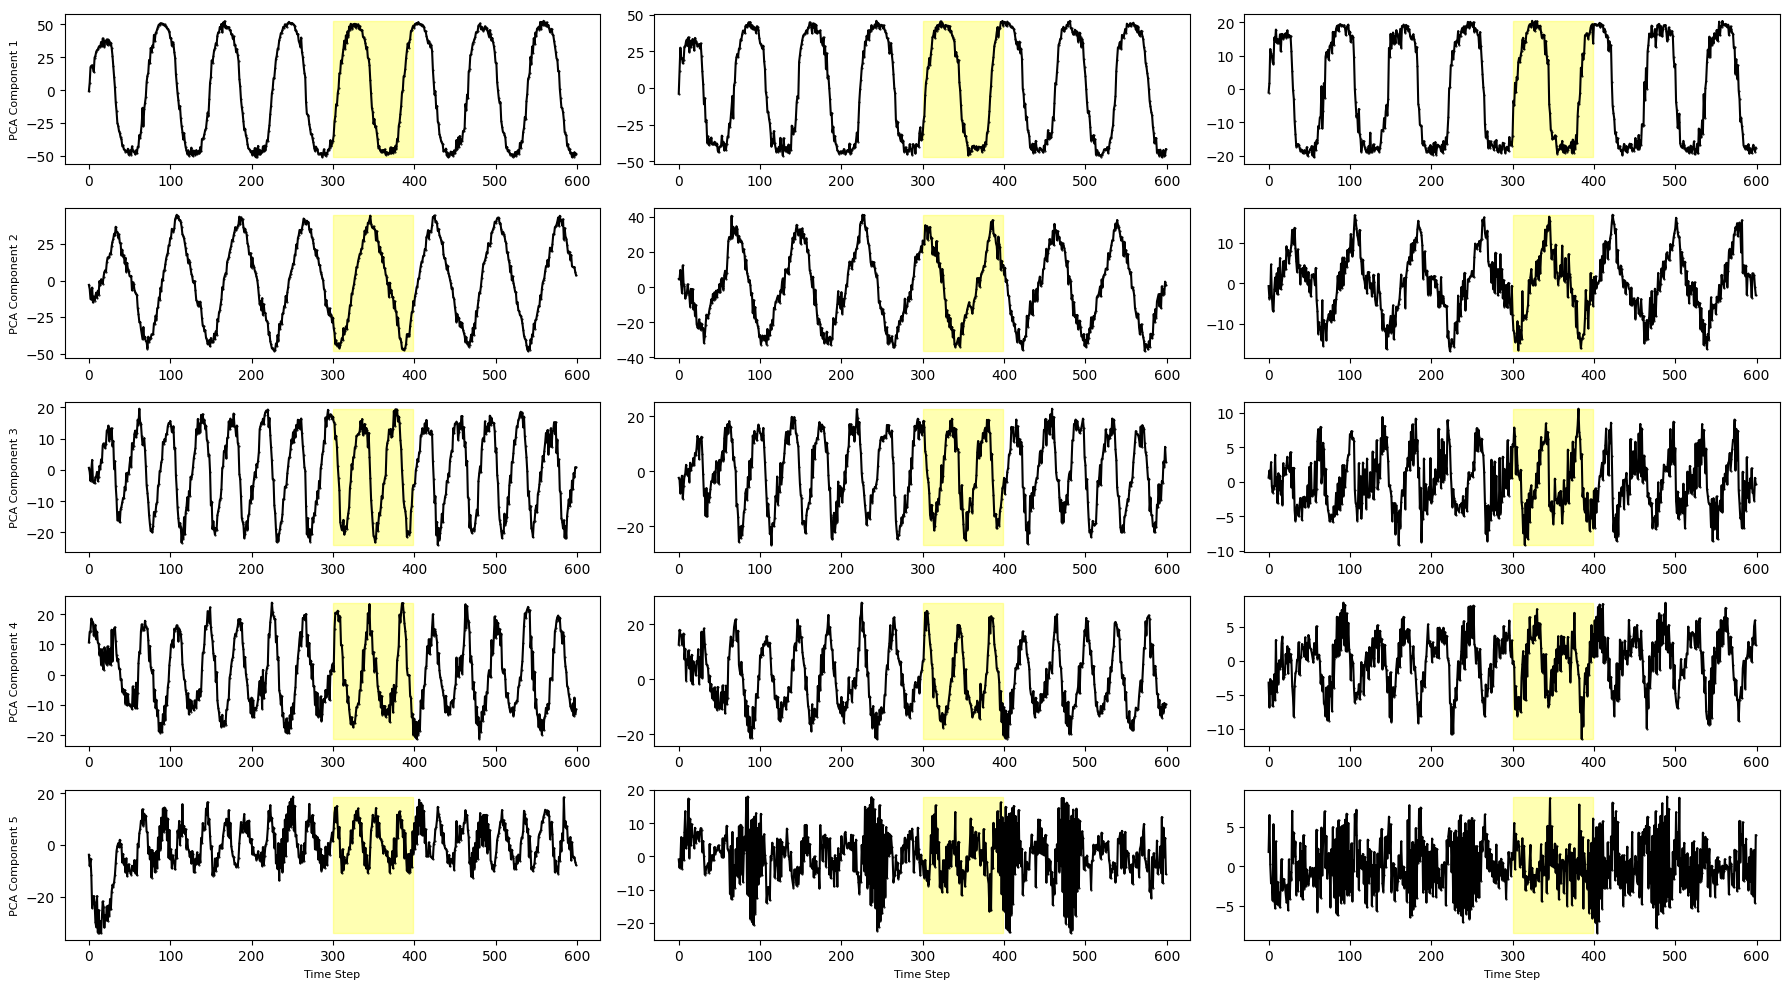

In [388]:
plot_list = [normal_hidden_weight["PCA_layer1"][0:600 , :] , normal_hidden_weight["PCA_layer2"][0:600 , :] ,normal_hidden_weight["PCA_layer3"][0:600 , :]]
PCA_plot_compare_single_component(plot_list , focus=[300,400])

Compare - No dif :(

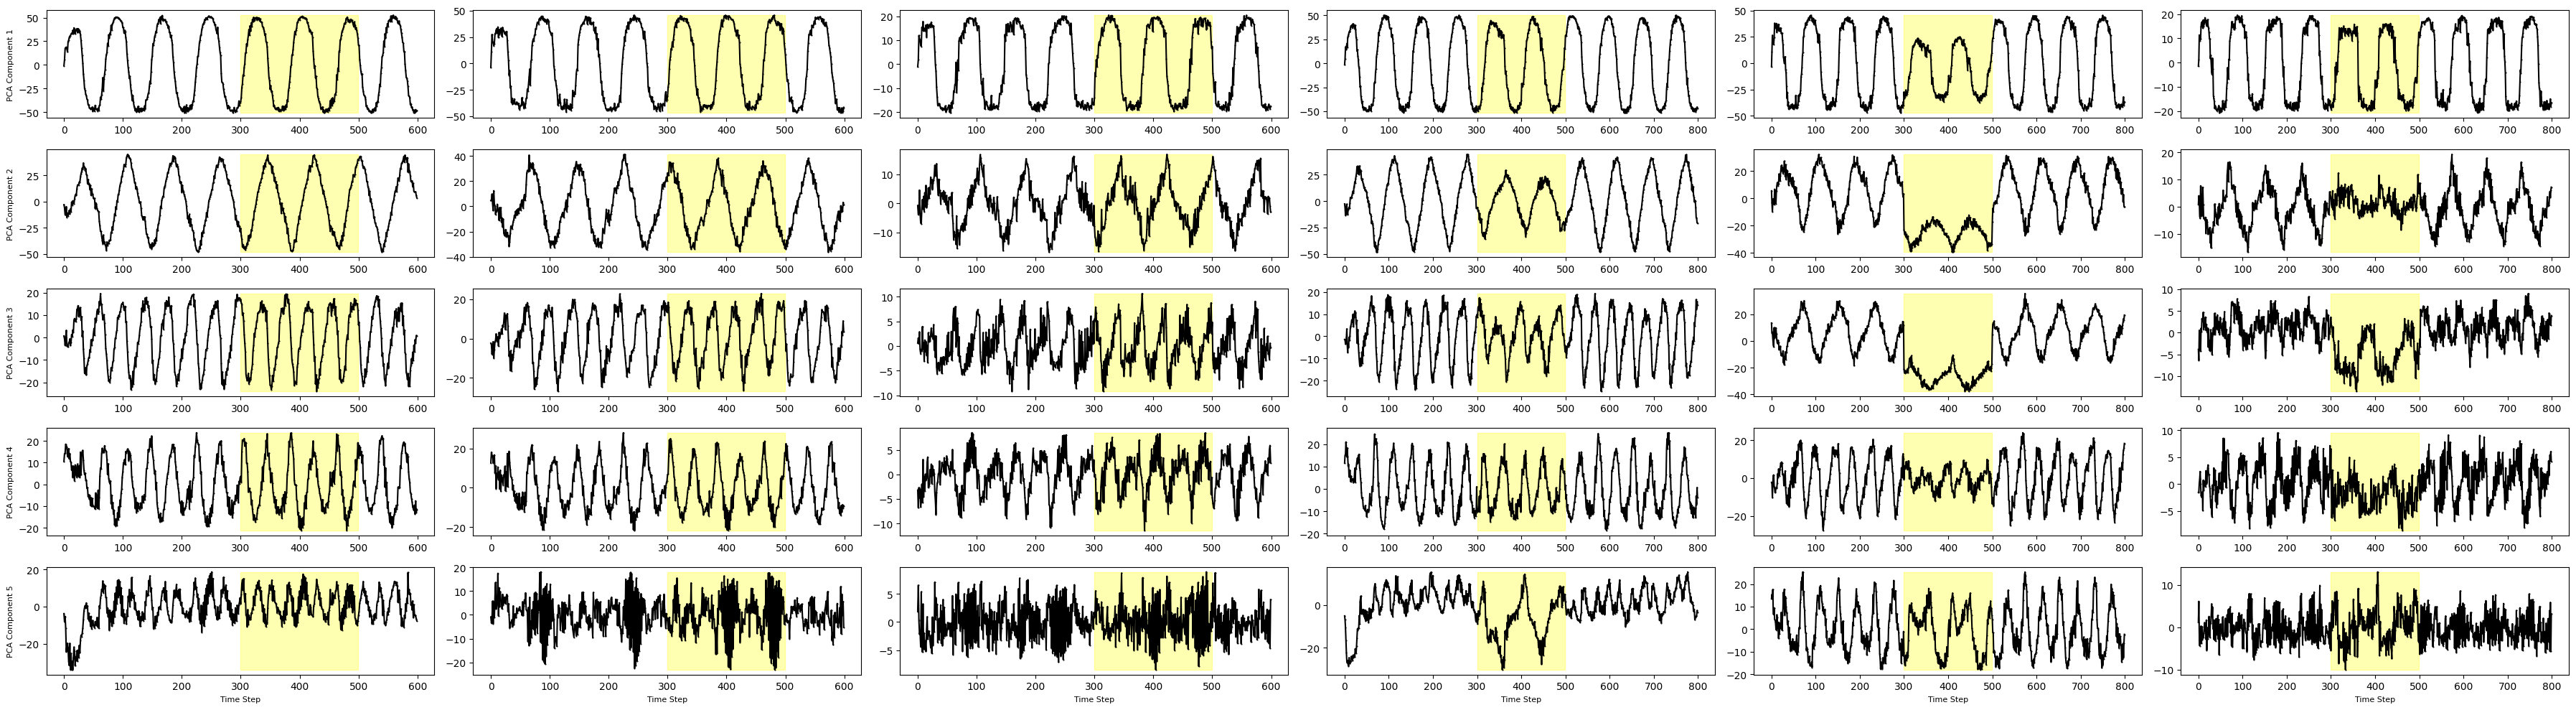

In [401]:
plot_list = [normal_hidden_weight["PCA_layer1"][0:600 , :] , normal_hidden_weight["PCA_layer2"][0:600 , :] ,normal_hidden_weight["PCA_layer3"][0:600 , :]] + [zero_long_hidden_weight["PCA_layer1"][0:800 , :] , zero_long_hidden_weight["PCA_layer2"][0:800 , :] ,zero_long_hidden_weight["PCA_layer3"][0:800 , :]]
PCA_plot_compare_single_component(plot_list , focus=[300,500])

### Sensory Group

In [420]:
pos_idx = np.arange(0,19)
vel_idx = np.arange(19,19*2)
action_idx = np.arange(19*2,19*3)
IMU_idx = np.arange(57,60)
fc_idx = np.arange(60,64)

In [427]:
zero_long["weight_hid_1"].shape

(1000, 64, 128)

In [431]:
pca_pos = pca.fit_transform(zero_long["weight_hid_1"][:,pos_idx,:].reshape(zero_long["weight_hid_1"].shape[0] , -1))
pca_vel = pca.fit_transform(zero_long["weight_hid_1"][:,vel_idx,:].reshape(zero_long["weight_hid_1"].shape[0] , -1))
pca_action = pca.fit_transform(zero_long["weight_hid_1"][:,action_idx,:].reshape(zero_long["weight_hid_1"].shape[0] , -1))
pca_IMU = pca.fit_transform(zero_long["weight_hid_1"][:,IMU_idx,:].reshape(zero_long["weight_hid_1"].shape[0] , -1))
pca_fc = pca.fit_transform(zero_long["weight_hid_1"][:,fc_idx,:].reshape(zero_long["weight_hid_1"].shape[0] , -1))

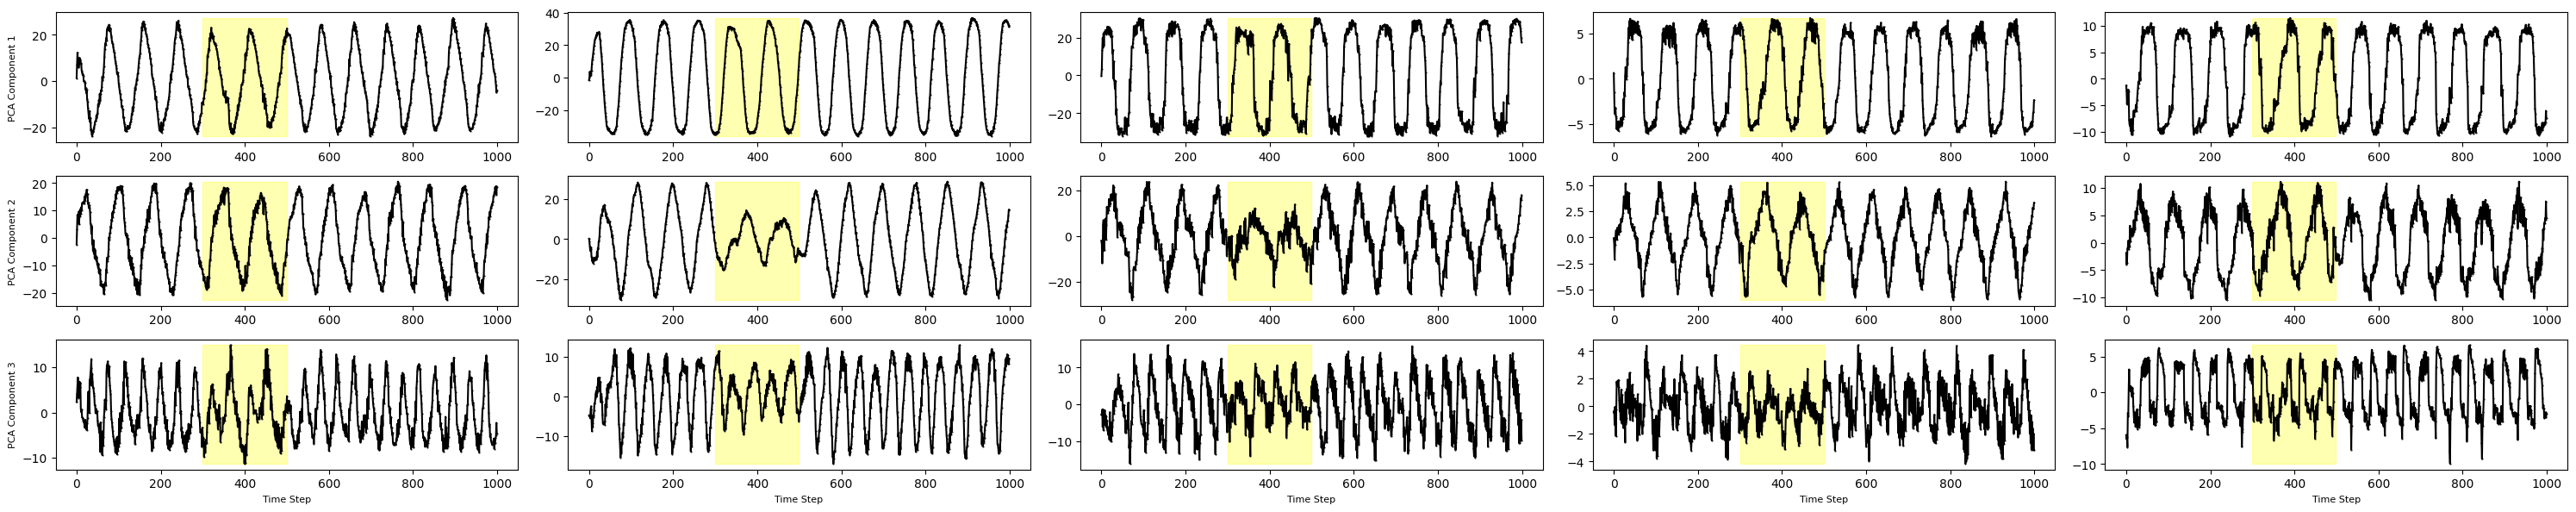

In [432]:
PCA_plot_compare_single_component([pca_pos , pca_vel , pca_action , pca_IMU , pca_fc] , focus=[300,500])

## Important Joint

In [410]:
zero_long["input"].shape
num_joint = 19
joint_idx = []
for i in range(num_joint):
    temp = [i , num_joint + i , 2*num_joint +i]
    joint_idx.append(temp)
joint_idx = np.array(joint_idx)

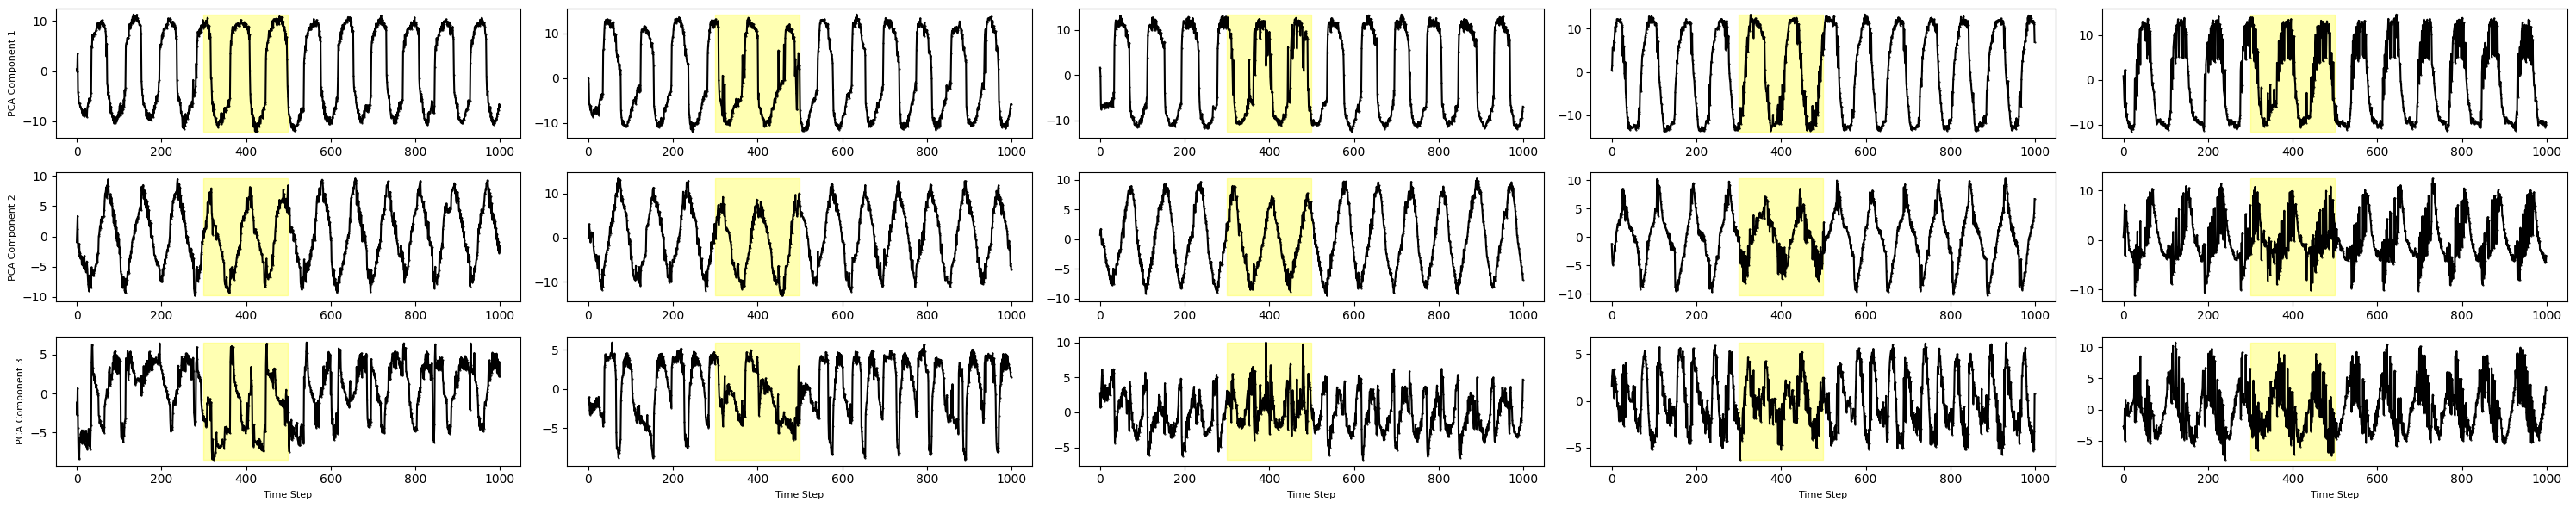

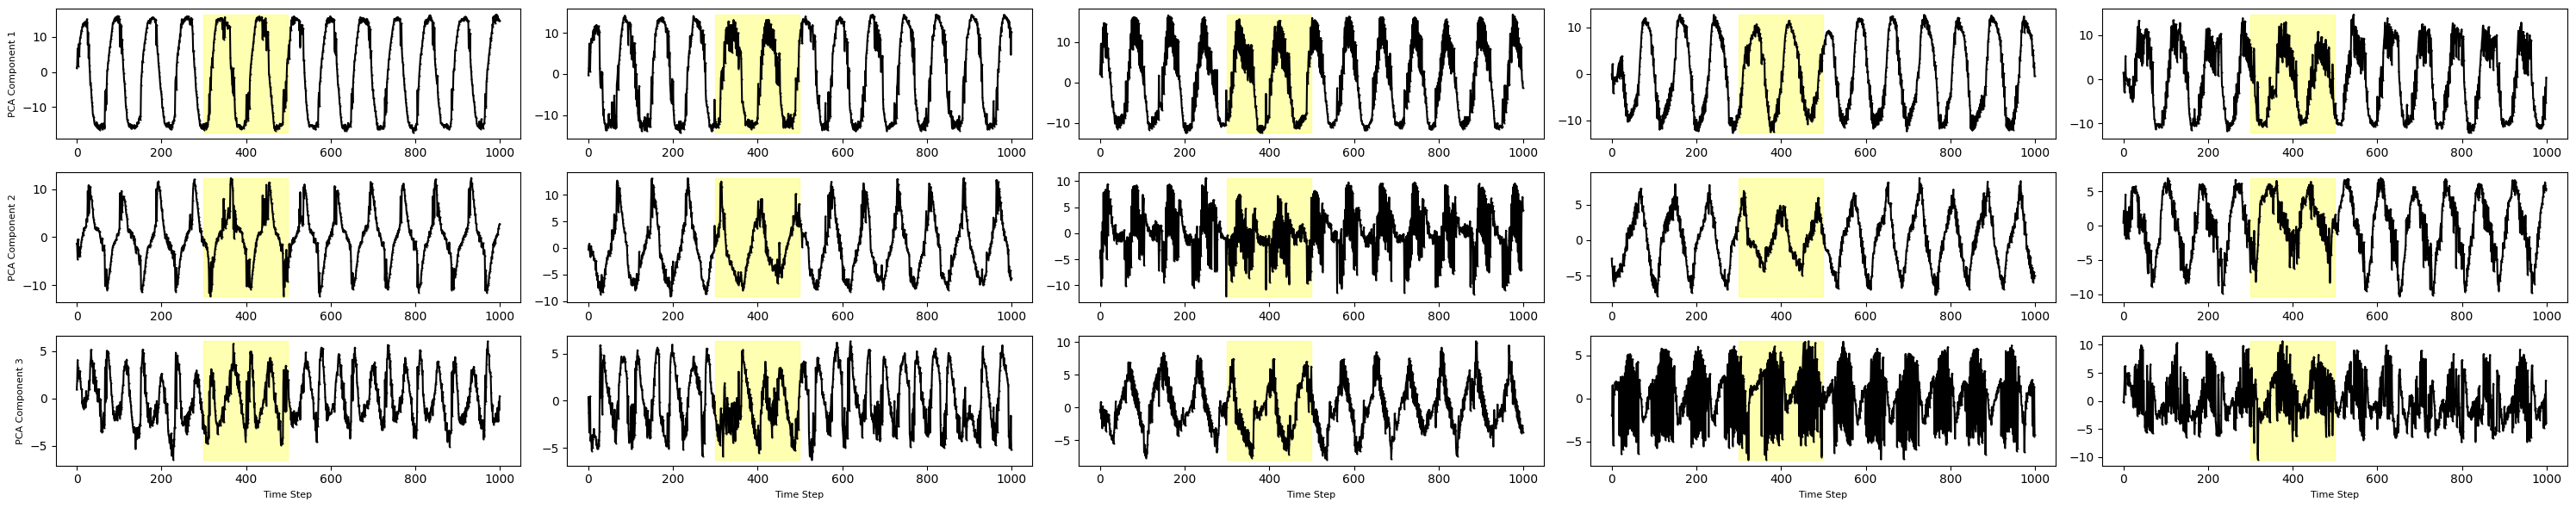

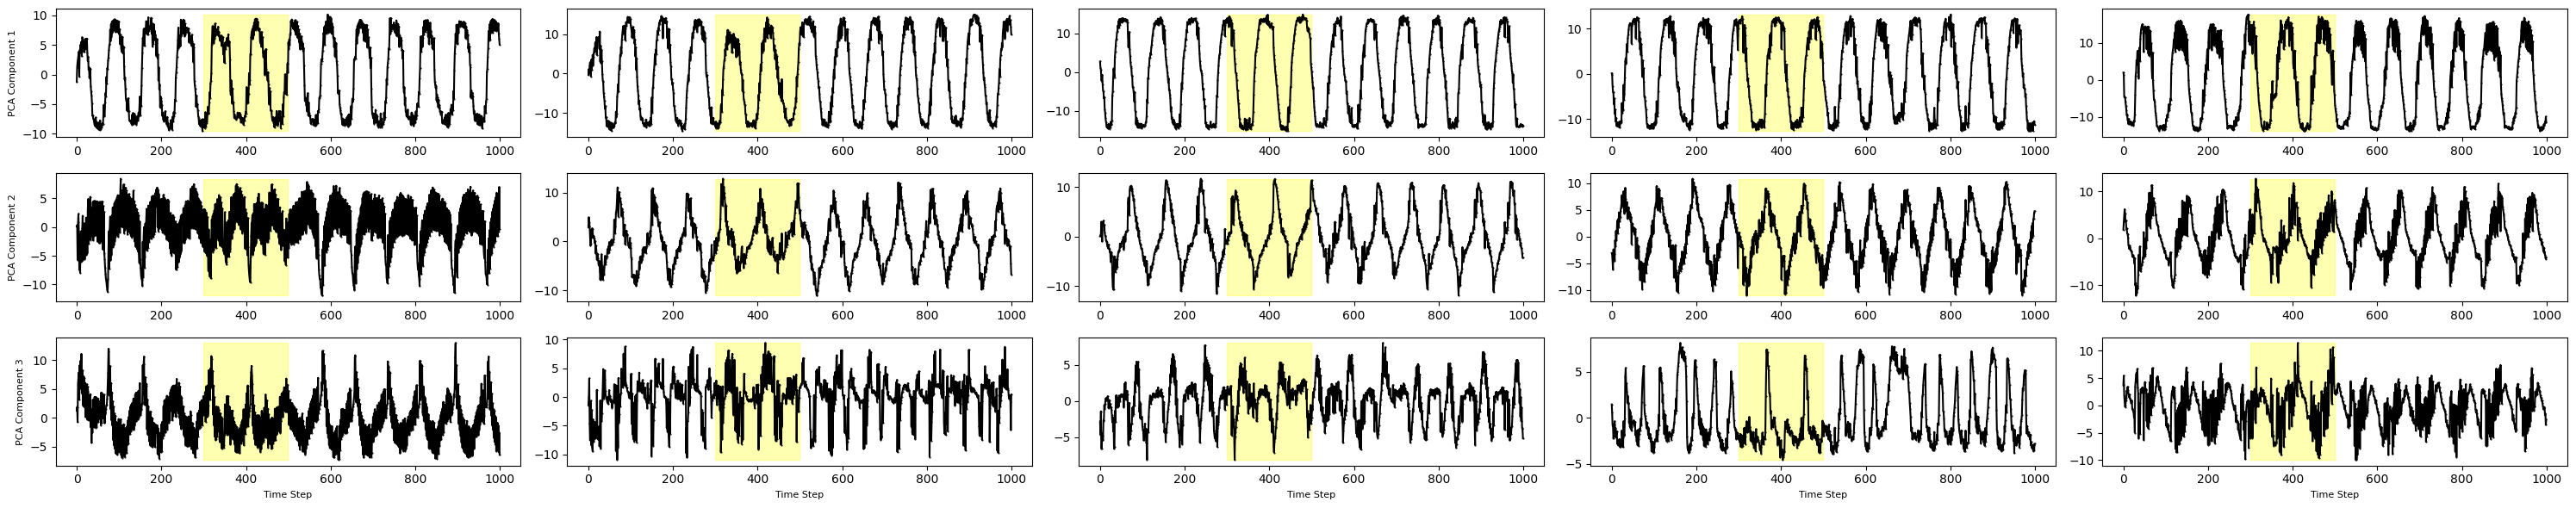

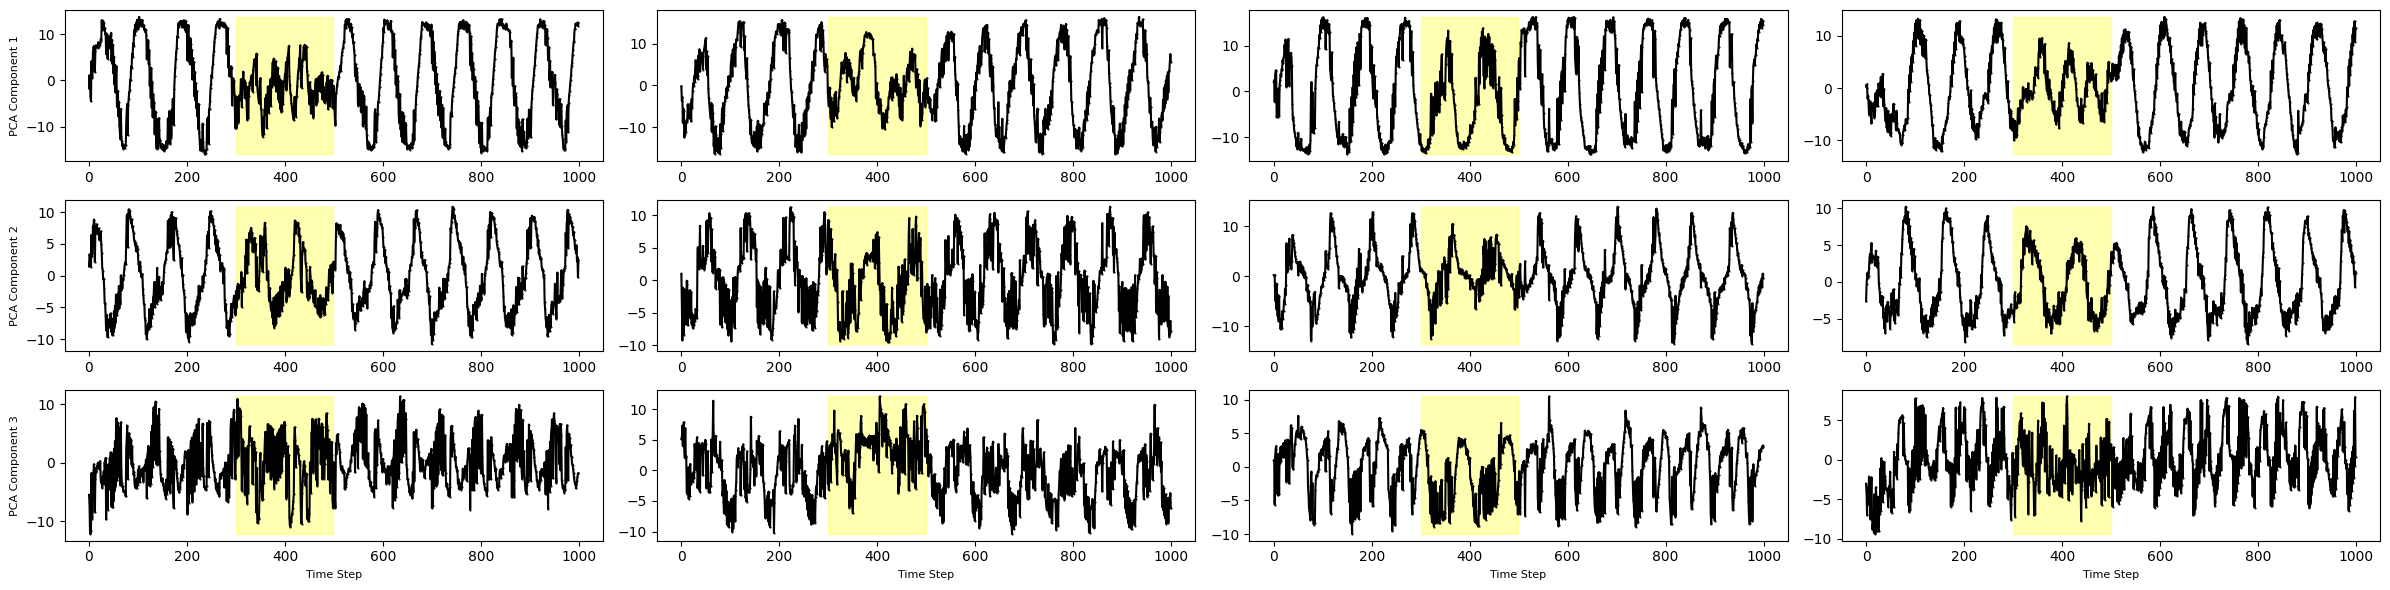

In [443]:
joint_set = []
for i in range(len(joint_idx)):
    j = pca.fit_transform(zero_long["weight_hid_1"][:,joint_idx[i],:].reshape(zero_long["weight_hid_1"].shape[0] , -1))
    joint_set.append(j)
PCA_plot_compare_single_component(joint_set[:5] , focus=[300,500] , name="compare1_5")
PCA_plot_compare_single_component(joint_set[5:10] , focus=[300,500] , name="compare2_5")
PCA_plot_compare_single_component(joint_set[10:15] , focus=[300,500] , name="compare3_5")
PCA_plot_compare_single_component(joint_set[15:20] , focus=[300,500] , name="compare4_4")